In [1]:
import os
import gc
import six
import math
import scipy
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression, LinearRegression

### 1. Прочитайте и проанализируйте данные

In [2]:
DATA_FOLDER = 'chgk'

results = pd.read_pickle(os.path.join(DATA_FOLDER, 'results.pkl'))
tournaments = pd.read_pickle(os.path.join(DATA_FOLDER, 'tournaments.pkl'))
players_catalog = pd.read_pickle(os.path.join(DATA_FOLDER, 'players.pkl'))

In [3]:
TRAIN_YEAR = 2019
TEST_YEAR = 2020

In [4]:
def is_valid_team(team_dict):
    if team_dict['players'] and team_dict['answers']:
        return True
    else:
        return False
    

def is_valid_tournament(tournament_dict):
    teams = tournament_dict['teams']
    if not teams:
        return False
    
    num_answers = None
    for team in teams:
        answers = team['answers']
        num_answers = num_answers or len(answers)
        if num_answers != len(answers):
            return False
    
    return True


def get_answers(answers):
    if not isinstance(answers, six.string_types) or set(answers) - {'0', '1'}:
        return list()
    return list(int(a) for a in answers)


def get_unique_players(data):
    result = set()

    for tournament in tqdm(data): 
        teams = tournament['teams']
        for team in teams:
            players = team['players']
            result.update(players)
            
    return result


def get_train_test(tournaments, results):
    train = []
    test = []
    for tournament_info in tqdm(tournaments.values()):
        tournament_year = datetime.fromisoformat(tournament_info['dateStart']).year
        if tournament_year not in (TRAIN_YEAR, TEST_YEAR):
            continue
    
        tournament_id = tournament_info['id']
        tournament_name = tournament_info['name']
        
        tournament_result = results[tournament_id]
        if not tournament_result:
            continue
    
        teams = []
        for team in tournament_result:
            team_id = team['team']['id']
        
            answers = get_answers(team.get('mask'))
        
            players = []
            for member in team['teamMembers']:
                player_id = member['player']['id']
                players.append(player_id)
        
            team_dict = {
                    'id': team_id,
                    'answers' : answers,
                    'players': players,
                }
            if not is_valid_team(team_dict):
                continue
            teams.append(team_dict)
        
        tournament_dict = {
                'id': tournament_id,
                'name': tournament_name,
                'teams': teams,
            }
        if not is_valid_tournament(tournament_dict):
            continue
        if tournament_year == TRAIN_YEAR:
            train.append(tournament_dict)
        else:
            test.append(tournament_dict)
            
    return train, test

In [5]:
train, test = get_train_test(tournaments, results)

del tournaments
gc.collect()

  0%|          | 0/5528 [00:00<?, ?it/s]

11076

In [6]:
unique_players = get_unique_players(train)
num_players = len(unique_players)
player_to_idx = {player: idx for idx, player in enumerate(unique_players)}

player_num_answers = np.zeros(num_players)
player_num_correct_answers = np.zeros(num_players)
player_num_tournaments = np.zeros(num_players)
player_teams = [set() for _ in range(num_players)]

num_questions = 0
unique_teams = set()
for tournament in tqdm(train): 
    teams = tournament['teams']
    
    first_team = True
    for team in teams:
        team_id = team['id']
        unique_teams.add(team_id)
        
        answers = team['answers']
        num_answers = len(answers)
        num_correct_answers = sum(answers)
        if first_team:
            num_questions += num_answers
        
        players = team['players']
        for player in players:
            player_idx = player_to_idx[player]
            player_num_answers[player_idx] += num_answers
            player_num_correct_answers[player_idx] += num_correct_answers
            player_num_tournaments[player_idx] += 1
            player_teams[player_idx].add(team_id)
        
        first_team = False
        
player_num_teams = np.array([len(pt) for pt in player_teams])
player_correct_ratio = player_num_correct_answers / player_num_answers

  0%|          | 0/604 [00:00<?, ?it/s]

  0%|          | 0/604 [00:00<?, ?it/s]

In [7]:
print('В обучающем наборе:')
print(f'Уникальных игроков: {num_players}')
print(f'Команд: {len(unique_teams)}')
print(f'Всего вопросов: {num_questions}')
print(f'В среднем вопросов на турнир: {int(num_questions / len(train))}')

В обучающем наборе:
Уникальных игроков: 55151
Команд: 10996
Всего вопросов: 28264
В среднем вопросов на турнир: 46


In [29]:
pairs = [
    ('В скольких турнирах участвовали игроки', player_num_tournaments),
    ('В скольких командах находились игроки', player_num_teams),
    ('На сколько вопросов ответили игроки', player_num_answers),
    ('На сколько вопросов ответили правильно', player_num_correct_answers),
    ('Доля правильных ответов у игроков', player_correct_ratio)
]

info = pd.DataFrame()
for pair in pairs:
    temp_info = pd.Series(pair[1]).describe().to_frame().T
    temp_info['Показатель'] = pair[0]
    info = info.append(temp_info, ignore_index=True)
info = info[['Показатель',] + [col for col in info.columns if col != 'Показатель']]

info

,Показатель,count,mean,std,min,25%,50%,75%,max
0,В скольких турнирах участвовали игроки,55151.0,6.220341,11.658492,1.0,1.000000,2.000000,5.00000,184.000000
1,В скольких командах находились игроки,55151.0,1.593552,1.980362,1.0,1.000000,1.000000,1.00000,54.000000
2,На сколько вопросов ответили игроки,55151.0,249.307955,466.594843,24.0,36.000000,72.000000,216.00000,7075.000000
3,На сколько вопросов ответили правильно,55151.0,107.220105,244.196935,0.0,11.000000,25.000000,80.00000,4061.000000
4,Доля правильных ответов у игроков,55151.0,0.337397,0.163131,0.0,0.214559,0.333333,0.45641,0.916667


### 2. Постройте baseline-модель на основе линейной или логистической регрессии

Воспользуемся логистической регрессией. Пусть x - будет объединение вектора вопроса и вектора игрока (в обоих случая воспользуемся one-hot-encoding), таргетом будет 1 - если ответ верный, иначе 0. В таком случае, вес перед вопросом будет прокси его сложности, а перед игроком - его "силы" как игрока. Тогда мы сможем получить рейтинг игроков, отражировав их.

In [9]:
def get_sparse_matrix(question_player):
    row = []
    col = []
    data = []
    
    max_row_idx = -1
    max_player_idx = -1
    for question_idx, player_idx_collection in enumerate(question_player):
        for row_idx, player_idx in enumerate(player_idx_collection, 1):
            if player_idx > max_player_idx:
                max_player_idx = player_idx
            row_idx += max_row_idx
            
            row.append(row_idx)
            col.append(question_idx)
            data.append(1)
            
            row.append(row_idx)
            col.append(len(question_player) + player_idx)
            data.append(1)
            
        max_row_idx = row_idx
    num_rows = max_row_idx + 1
    num_cols = max_player_idx + 1 + len(question_player)
    coo = scipy.sparse.coo_matrix((data, (row, col)), shape=(num_rows, num_cols), dtype=np.uint8)
    return coo


def get_data(question_player_correct, question_player_incorrect):
    correct_coo = get_sparse_matrix(question_player_correct)
    incorrect_coo = get_sparse_matrix(question_player_incorrect)
    
    X = scipy.sparse.vstack([correct_coo, incorrect_coo]).tocsr()
    y = np.array([1,] * correct_coo.shape[0] + [0,] * incorrect_coo.shape[0])
    
    return X, y

In [10]:
question_player_correct = [[] for _ in range(num_questions)]
question_player_incorrect = [[] for _ in range(num_questions)]
question_player_correct_team = [[] for _ in range(num_questions)]
question_player_incorrect_team = [[] for _ in range(num_questions)]

question_tournament = [None] * num_questions

max_question_id = -1
for tournament in tqdm(train): 
    tournament_name = tournament['name']
    teams = tournament['teams']
    for team in teams:
        team_id = team['id']
        answers = team['answers']
        players = team['players']
        for question_id, answer in enumerate(answers, 1):
            question_id += max_question_id
            
            question_tournament[question_id] = tournament_name
            
            for player in players:
                player_idx = player_to_idx[player]
                if answer == 1:
                    question_player_correct[question_id].append(player_idx)
                    question_player_correct_team[question_id].append(team_id)
                else:
                    question_player_incorrect[question_id].append(player_idx)
                    question_player_incorrect_team[question_id].append(team_id)
    
    max_question_id = question_id

  0%|          | 0/604 [00:00<?, ?it/s]

In [11]:
%%time

X, y = get_data(question_player_correct, question_player_incorrect)

lr = LogisticRegression(random_state=42, solver='saga', n_jobs=8)
lr.fit(X, y)

CPU times: user 2min 50s, sys: 674 ms, total: 2min 50s
Wall time: 2min 50s


LogisticRegression(n_jobs=8, random_state=42, solver='saga')

In [12]:
idx_to_player = {idx: player for player, idx in player_to_idx.items()}

player_baseline_ratings_ = {}
for idx, rating in enumerate(lr.coef_.flatten()[len(question_player_correct):]):
    player_baseline_ratings_[idx_to_player[idx]] = rating

player_baseline_ratings_ = dict(sorted(player_baseline_ratings_.items(), key=lambda x: -x[1]))

In [13]:
player_baseline_ratings = pd.Series(player_baseline_ratings_).reset_index()
player_baseline_ratings.columns = ['player_id', 'baseline_score']
top = player_baseline_ratings[:10].copy(deep=True)
top['name'] = top['player_id'].apply(lambda x: players_catalog[x]['name'])
top['surname'] = top['player_id'].apply(lambda x: players_catalog[x]['surname'])
top

,player_id,baseline_score,name,surname
0,27403,4.069292,Максим,Руссо
1,4270,3.932565,Александра,Брутер
2,28751,3.885219,Иван,Семушин
3,27822,3.853063,Михаил,Савченков
4,30270,3.758541,Сергей,Спешков
5,30152,3.752901,Артём,Сорожкин
6,18036,3.619236,Михаил,Левандовский
7,20691,3.614461,Станислав,Мереминский
8,87637,3.542881,Антон,Саксонов
9,22799,3.539576,Сергей,Николенко


Немного юмора: увидев участника на 10-й позиции, я понял что получен, по всей видимости корректный бейзлайн :)

### 3. Оценим качество рейтинг-системы для предсказаний результатов турниров

Для построения рейтинга команд, сделаем несколько грубое предположение, что "сила" команды равна сумме "силы" её отдельных игроков. Но думаю в рамках нашей задачи это допустимо.

In [14]:
def get_tournament_predict_and_fact(players_raiting, tournament_id):
    teams_strengths = []
    teams_fact_positions = []
    for team in results[tournament_id]:
        team_strength = []
        if team.get('position', None) is not None:
            teams_fact_positions.append(team['position'])
            for member in team['teamMembers']:
                if member['player']['id'] in players_raiting:
                    team_strength.append(players_raiting[member['player']['id']])
            if len(team_strength) > 0:
                teams_strengths.append(np.sum(team_strength))
            else:
                teams_strengths.append(float('-inf'))
    
    return np.argsort(teams_strengths)[::-1] + 1, teams_fact_positions


def get_correlations(players_raiting, verbose=True):
    spearmanr_vals = []
    kendalltau_vals = []
    for tournament_id in [x['id'] for x in test]:
        predicted, fact = get_tournament_predict_and_fact(players_raiting, tournament_id)
        spearmanr_vals.append(scipy.stats.spearmanr(predicted, fact).correlation)
        kendalltau_vals.append(scipy.stats.kendalltau(predicted, fact).correlation)
    
    spearmanr_res = np.mean(spearmanr_vals)
    kendalltau_res = np.mean(kendalltau_vals)
    if verbose:
        print(f'Корреляция Cпирмена: {spearmanr_res}')
        print(f'Корреляция Кенделла: {kendalltau_res}')
        
    return spearmanr_res, kendalltau_res


def get_correlations_for_model(model, verbose=False):
    player_baseline_ratings_t = {}
    for idx, rating in enumerate(model.coef_.flatten()[len(question_player_correct):]):
        player_baseline_ratings_t[idx_to_player[idx]] = rating

    player_baseline_ratings_t = dict(sorted(player_baseline_ratings_t.items(), key=lambda x: -x[1]))
    return get_correlations(player_baseline_ratings_t, verbose)

_ = get_correlations(player_baseline_ratings_)

Корреляция Cпирмена: 0.7869851816792957
Корреляция Кенделла: 0.6269617502172807


### 4. EM - алгоритм

В качестве скрытой переменной рассмотрим вероятность того, что игрок дал правильный ответ, при условии что
команда дала правильный ответ: <b>z = P(player_right|team_right)</b>  
Тогда: <b>z = (P(team_right|player_right) * P(player_right)) / P(team_right)</b>  
так же примем, что если член команды отвечает правильно, то и команда отвечает правильно:  
<b>z = P(player_right)) / P(team_right)</b>

In [15]:
def prepare_questions(question_player_correct_team, question_player_incorrect_team):
    # question_team
    question_team = []
    for team_collection in question_player_correct_team:
        question_team.extend(team_collection)
    for team_collection in question_player_incorrect_team:
        question_team.extend(team_collection)
    question_team = np.array(question_team)
    
    # question
    question = []
    for i in range(num_questions):
        tmp = [i] * len(question_player_correct[i])
        question.extend(tmp)
    for i in range(num_questions):
        tmp = [i] * len(question_player_incorrect[i])
        question.extend(tmp)
    question = np.array(question)
    
    return question, question_team


def get_preds(model, X):
    positive_preds = model.predict(X).clip(0, 1).reshape(-1, 1)
    negative_preds = (1 - positive_preds).reshape(-1, 1)
    return np.hstack((negative_preds, positive_preds))


def get_statistics(incorrect_proba, correct_proba):
    player_stats = pd.DataFrame({'team': question_team, 'question': question,
                                 'player_incorrect_proba': incorrect_proba, 'player_correct_proba': correct_proba})
    
    team_stats = (
        player_stats
        .groupby(['team', 'question'])['player_incorrect_proba']
        .prod()
        .reset_index()
        .rename(columns={'player_incorrect_proba': 'team_incorrect_proba'})
    )
    
    return player_stats, team_stats

In [16]:
question, question_team = prepare_questions(question_player_correct_team, question_player_incorrect_team)

In [17]:
n_iterations = 9

spe_vals = []
ken_vals = []

model = LinearRegression()
model.fit(X, y)
print('Изначально')
spe, ken = get_correlations_for_model(model, verbose=True)
spe_vals.append(spe)
ken_vals.append(ken)
print()

for i in range(n_iterations):
    # E-шаг
    preds = get_preds(model, X)
    
    player_stats, team_stats = get_statistics(preds[:, 0], preds[:, 1])
    team_stats['team_correct_proba'] = 1 - team_stats['team_incorrect_proba']
    all_stats = player_stats.merge(team_stats, on=['team', 'question'])
    z = (all_stats['player_correct_proba'] / all_stats['team_correct_proba']).fillna(1).values.clip(0, 1)
    z[y == 0] = 0
    
    # M-шаг
    model.fit(X, z)
    
    # корреляции
    print(f'{i+1}-я итерация')
    spe, ken = get_correlations_for_model(model, verbose=True)
    spe_vals.append(spe)
    ken_vals.append(ken)
    print()

Изначально
Корреляция Cпирмена: 0.7817402198492948
Корреляция Кенделла: 0.6213811841733065

1-я итерация
Корреляция Cпирмена: 0.7859822584513921
Корреляция Кенделла: 0.625757114600424

2-я итерация
Корреляция Cпирмена: 0.7843007954115274
Корреляция Кенделла: 0.6241014633402213

3-я итерация
Корреляция Cпирмена: 0.7859929463601041
Корреляция Кенделла: 0.6258155225775321

4-я итерация
Корреляция Cпирмена: 0.7865118800578677
Корреляция Кенделла: 0.6265643269895476

5-я итерация
Корреляция Cпирмена: 0.7880819666444869
Корреляция Кенделла: 0.6285206136159233

6-я итерация
Корреляция Cпирмена: 0.7882896644282175
Корреляция Кенделла: 0.6290385837813289

7-я итерация
Корреляция Cпирмена: 0.7880301556024264
Корреляция Кенделла: 0.6290062797356902

8-я итерация
Корреляция Cпирмена: 0.7880230360626501
Корреляция Кенделла: 0.6291536233255601

9-я итерация
Корреляция Cпирмена: 0.7887169103130619
Корреляция Кенделла: 0.6295434492540769



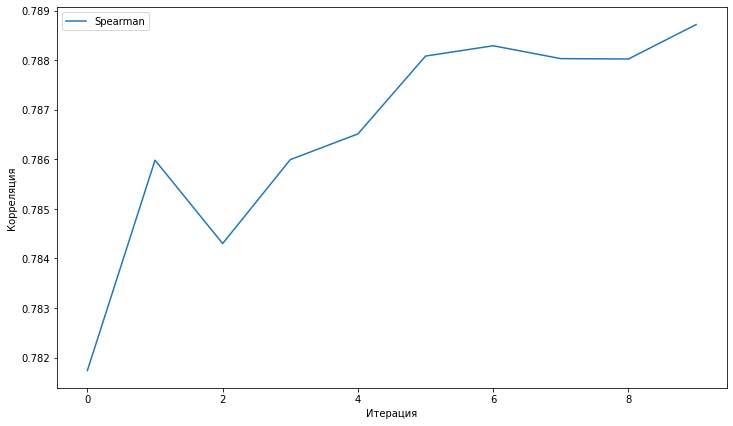

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(range(10), spe_vals, label='Spearman')
plt.xlabel('Итерация')
plt.ylabel('Корреляция')
plt.legend()
plt.show()

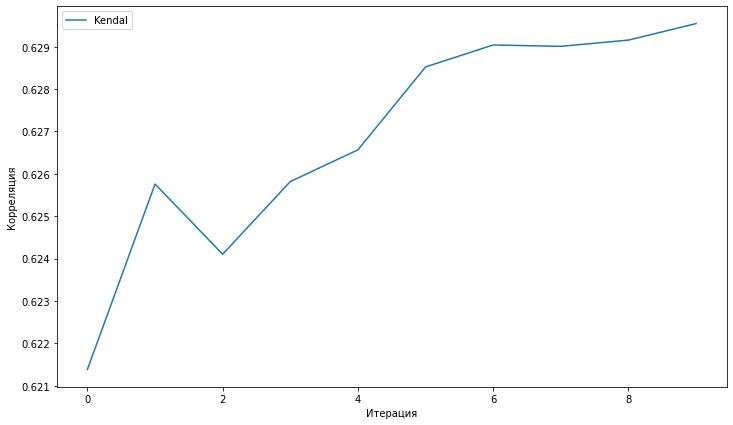

In [19]:
plt.figure(figsize=(12, 7))
plt.plot(range(10), ken_vals, label='Kendal')
plt.xlabel('Итерация')
plt.ylabel('Корреляция')
plt.legend()
plt.show()

Видим, что с количеством итераций коэффициенты корреляции действительно растут. Лучшая модель (на основе метрик), получена на 9-й итерации EM-алгоритма.

### 5. Постройте “рейтинг-лист” турниров по сложности вопросов

Снова воспользуемся предположением, что "сложность" турнира равна сумме "сложности" его вопросов.

In [20]:
question_ratings = collections.defaultdict(int)
for idx, rating in enumerate(model.coef_.flatten()[:len(question_tournament)]):
    question_ratings[question_tournament[idx]] += rating

question_ratings = dict(sorted(question_ratings.items(), key=lambda x: x[1]))

question_ratings = pd.Series(question_ratings).reset_index()
question_ratings.columns = ['tournament_name', 'score']
question_ratings['rating'] = range(1, len(question_ratings) + 1)
question_ratings = question_ratings[['rating', 'tournament_name']]

Топ-20 (наиболее сложные)

In [21]:
question_ratings.head(20)

,rating,tournament_name
0,1,Чемпионат Санкт-Петербурга. Первая лига
1,2,Чемпионат Санкт-Петербурга. Высшая лига
2,3,Чемпионат России
3,4,AU
4,5,Весна в ЛЭТИ
5,6,Угрюмый Ёрш
6,7,Беловежская Зима
7,8,Кубок Европы среди студентов
8,9,Кубок Физтеха
9,10,Крутое пике


Последние-20 (наиболее простые)

In [22]:
question_ratings.tail(20)

,rating,tournament_name
578,579,(а)Синхрон-lite. Лига старта. Эпизод VII
579,580,Кубок Тышкевичей
580,581,Асинхрон по «Королю и Шуту»
581,582,(а)Синхрон-lite. Лига старта. Эпизод IX
582,583,Первая лига ЧТ
583,584,Школьный чемпионат России
584,585,Межфакультетский кубок МГУ. Отбор №4
585,586,Die Hard
586,587,Кубок Закарпатья
587,588,(А) Славянка без раздаток. 4 этап


Выглядит похожим на правду. Например, в первые 20 попадают: "Чемпионат Санкт-Петербурга. Первая лига", "Чемпионат России", "Кубок Европы среди студентов". В свою очередь в последние 20, попадают: "Школьный чемпионат России", "Второй тематический турнир имени Джоуи Триббиани", "Асинхрон по South Park".